In [2]:
!pip install -U -q opendatasets opencv-python ultralytics

In [3]:
import os
import glob
import random
import yaml

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import opendatasets as od

import torch
assert torch.cuda.is_available(), "CUDA not available"
import ultralytics
from ultralytics import YOLO, settings

In [4]:
BYTES_IN_GB = 1000_000_000

def print_mem():
    (free, total) = torch.cuda.mem_get_info()
    used = total - free
    
    perc_usaged = round(used / total * 100.0, 1)
    used_gb = round(used / BYTES_IN_GB, 1)
    total_gb = round(total / BYTES_IN_GB, 1)
    print(f'CUDA mem usage: {used_gb}/{total_gb}GB ({perc_usaged}%)')

print_mem()

CUDA mem usage: 1.0/12.5GB (8.2%)


In [5]:
ultralytics.checks()
settings

Ultralytics 8.3.77 🚀 Python-3.11.8 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4070, 11877MiB)
Setup complete ✅ (20 CPUs, 31.1 GB RAM, 455.7/1189.4 GB disk)


{'settings_version': '0.0.6',
 'datasets_dir': '/home/jovyan/notebooks/BrainScan/datasets',
 'weights_dir': 'weights',
 'runs_dir': 'runs',
 'uuid': '188a02b39512c2c610392912d8f3f7376b8d2a0e170c1c9c780bcf8d0fa0651b',
 'sync': True,
 'api_key': '',
 'openai_api_key': '',
 'clearml': True,
 'comet': True,
 'dvc': True,
 'hub': True,
 'mlflow': True,
 'neptune': True,
 'raytune': True,
 'tensorboard': True,
 'wandb': False,
 'vscode_msg': True}

In [6]:
if not os.path.exists("./datasets"):
    od.download('https://www.kaggle.com/datasets/ultralytics/brain-tumor/data')
if os.path.exists("./brain-tumor"):
    os.rename("./brain-tumor", "./datasets")

In [7]:
base_dir = "./datasets"

train_dir = f"{base_dir}/brain-tumor/train"
valid_dir = f"{base_dir}/brain-tumor/valid"
test_dir = f"{base_dir}/brain-tumor/test"

Image `./datasets/brain-tumor/train/images/79 (2).jpg` has shape: (512, 512, 3)
Image `./datasets/brain-tumor/train/images/115.jpg` has shape: (256, 256, 3)
Image `./datasets/brain-tumor/train/images/00090_130.jpg` has shape: (512, 512, 3)


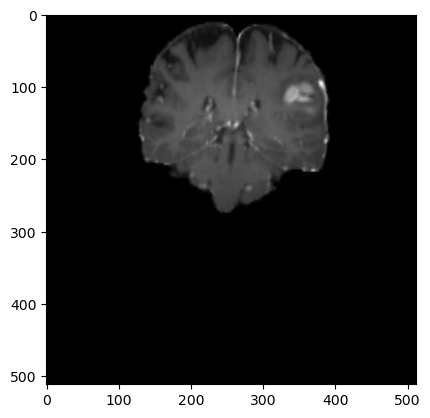

In [8]:
sample_files = glob.glob(train_dir + "/images/*.jpg")
samples = random.sample(sample_files, k=3)

sample_images = []
for sample in samples:
    image = cv2.imread(sample)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sample_images.append(image)
    print(f"Image `{sample}` has shape: {image.shape}")

len(sample_images)

plt.imshow(sample_images[0])

In [9]:
class_mapping = {
    0: 'negative',
    1: 'positive'
}

def read_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

def read_labels(label_dir, image_full_path): 
    """
    Output is a list of lists. Where each sublist has 5 float values.
    """

    labels = []
    
    (image_dir, image_path) = os.path.split(image_full_path) 
    (image_name, _ext) = os.path.splitext(image_path)

    label_path = os.path.join(label_dir, image_name + ".txt")
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.read().split("\n")
            labels = [
                [float(value) for value in line.split()] for line in lines
            ]

    return labels

def dir_to_data(directory):
    image_dir = os.path.join(directory, "images")
    label_dir = os.path.join(directory, "labels")

    image_paths = glob.glob(image_dir + "/*.jpg")
    print(f'Total of {len(image_paths)} images found')

    names = []
    images = []
    labels = []
    unlabeled = []
    for image_path in image_paths:
        image = read_image(image_path)
        image_labels = read_labels(label_dir, image_path)

        
        if len(image_labels) > 0:
            for image_label in image_labels:
                names.append(os.path.split(image_path)[-1])
                images.append(image)
                labels.append(image_label)
        else:
            unlabeled.append(image_path)

    print(f'Total of {len(images)} labeled images found (some may contain duplicate labels)')
    print(f'Total of {len(unlabeled)} unlabeled images found')

    class_distribution = {'negative': 0, 'positive': 0}
    for label in labels:
        cls = class_mapping[int(label[0])]
        class_distribution[cls] +=1
    
    print('Class distribution: ', class_distribution)
    return (names, images, labels, unlabeled)

(names, images, labels, unlabeled) = dir_to_data(train_dir)

assert len(images) == len(labels), "Mismatch in images and labels"

Total of 893 images found
Total of 925 labeled images found (some may contain duplicate labels)
Total of 15 unlabeled images found
Class distribution:  {'negative': 437, 'positive': 488}


In [10]:
def split_test_data(force = False):
    if os.path.exists(test_dir) and not force:
        print("Test data was already split")
        return 
        
    os.makedirs(test_dir)
    os.makedirs(test_dir + '/images')
    os.makedirs(test_dir + '/labels')
    
    image_list = glob.glob(valid_dir + "/images/*.jpg")
    label_list = glob.glob(valid_dir + "/labels/*.txt")

    print(f'Total of {len(image_list)}/{len(label_list)} of validation images/labels')

    test_n = int(len(image_list) / 3) # for a 2:1 split between validation and test data
    
    print(f'Moving {test_n}# images/labels from /valid to /test')
    
    test_list = random.sample(image_list, k=test_n)

    for full_image_path in test_list:
        image_path = os.path.split(full_image_path)[-1]
        image_name = os.path.splitext(image_path)[0]
        label_name = image_name + ".txt"
        full_label_path = os.path.join(valid_dir, "labels", label_name)

        if os.path.exists(full_label_path):
            new_image_path = os.path.join(test_dir, "images", image_path)
            new_label_path = os.path.join(test_dir, "labels", label_name)
            
            os.rename(full_image_path, new_image_path)
            os.rename(full_label_path, new_label_path)

    v_i = len(glob.glob(valid_dir + "/images/*.jpg"))
    v_l = len(glob.glob(valid_dir + "/labels/*.txt"))

    t_i = len(glob.glob(test_dir + "/images/*.jpg"))
    t_l = len(glob.glob(test_dir + "/labels/*.txt"))  

    print(f'Total of ({v_i}/{v_l}) , ({t_i}/{t_l}) of validation/test, images/labels')

split_test_data()

Test data was already split


In [11]:
import pandas as pd
df = pd.DataFrame([image.shape for image in images], columns=['w','h','d'])
df.describe()

,w,h,d
count,925.000000,925.000000,925.0
mean,431.809730,417.660541,3.0
std,117.995224,137.699628,0.0
min,256.000000,192.000000,3.0
25%,256.000000,256.000000,3.0
50%,512.000000,512.000000,3.0
75%,512.000000,512.000000,3.0
max,512.000000,512.000000,3.0


In [12]:
def show_images(names, images, labels):
    fig, axs = plt.subplots(int(len(images) / 5), 5, figsize=(20, 20))
    axs = axs.flatten()
    
    for i, (name, image, label) in enumerate(zip(names, images, labels)):
        img_height, img_width, _dim = image.shape
        
        lbl_id, lbl_center_x, lbl_center_y, lbl_width, lbl_height = label
        
        x_0 = (lbl_center_x - lbl_width / 2) * img_width
        x_w = img_width * lbl_width
        y_0 = (lbl_center_y - lbl_height / 2) * img_height
        y_w = img_height * lbl_height

        color = ['r', 'b'][int(lbl_id)]
        
        rect = patches.Rectangle((x_0, y_0), x_w, y_w, linewidth=2, edgecolor=color, facecolor='none')

        axs[i].imshow(image)
        axs[i].set_title(name)
        axs[i].add_patch(rect)        
        axs[i].axis("off")

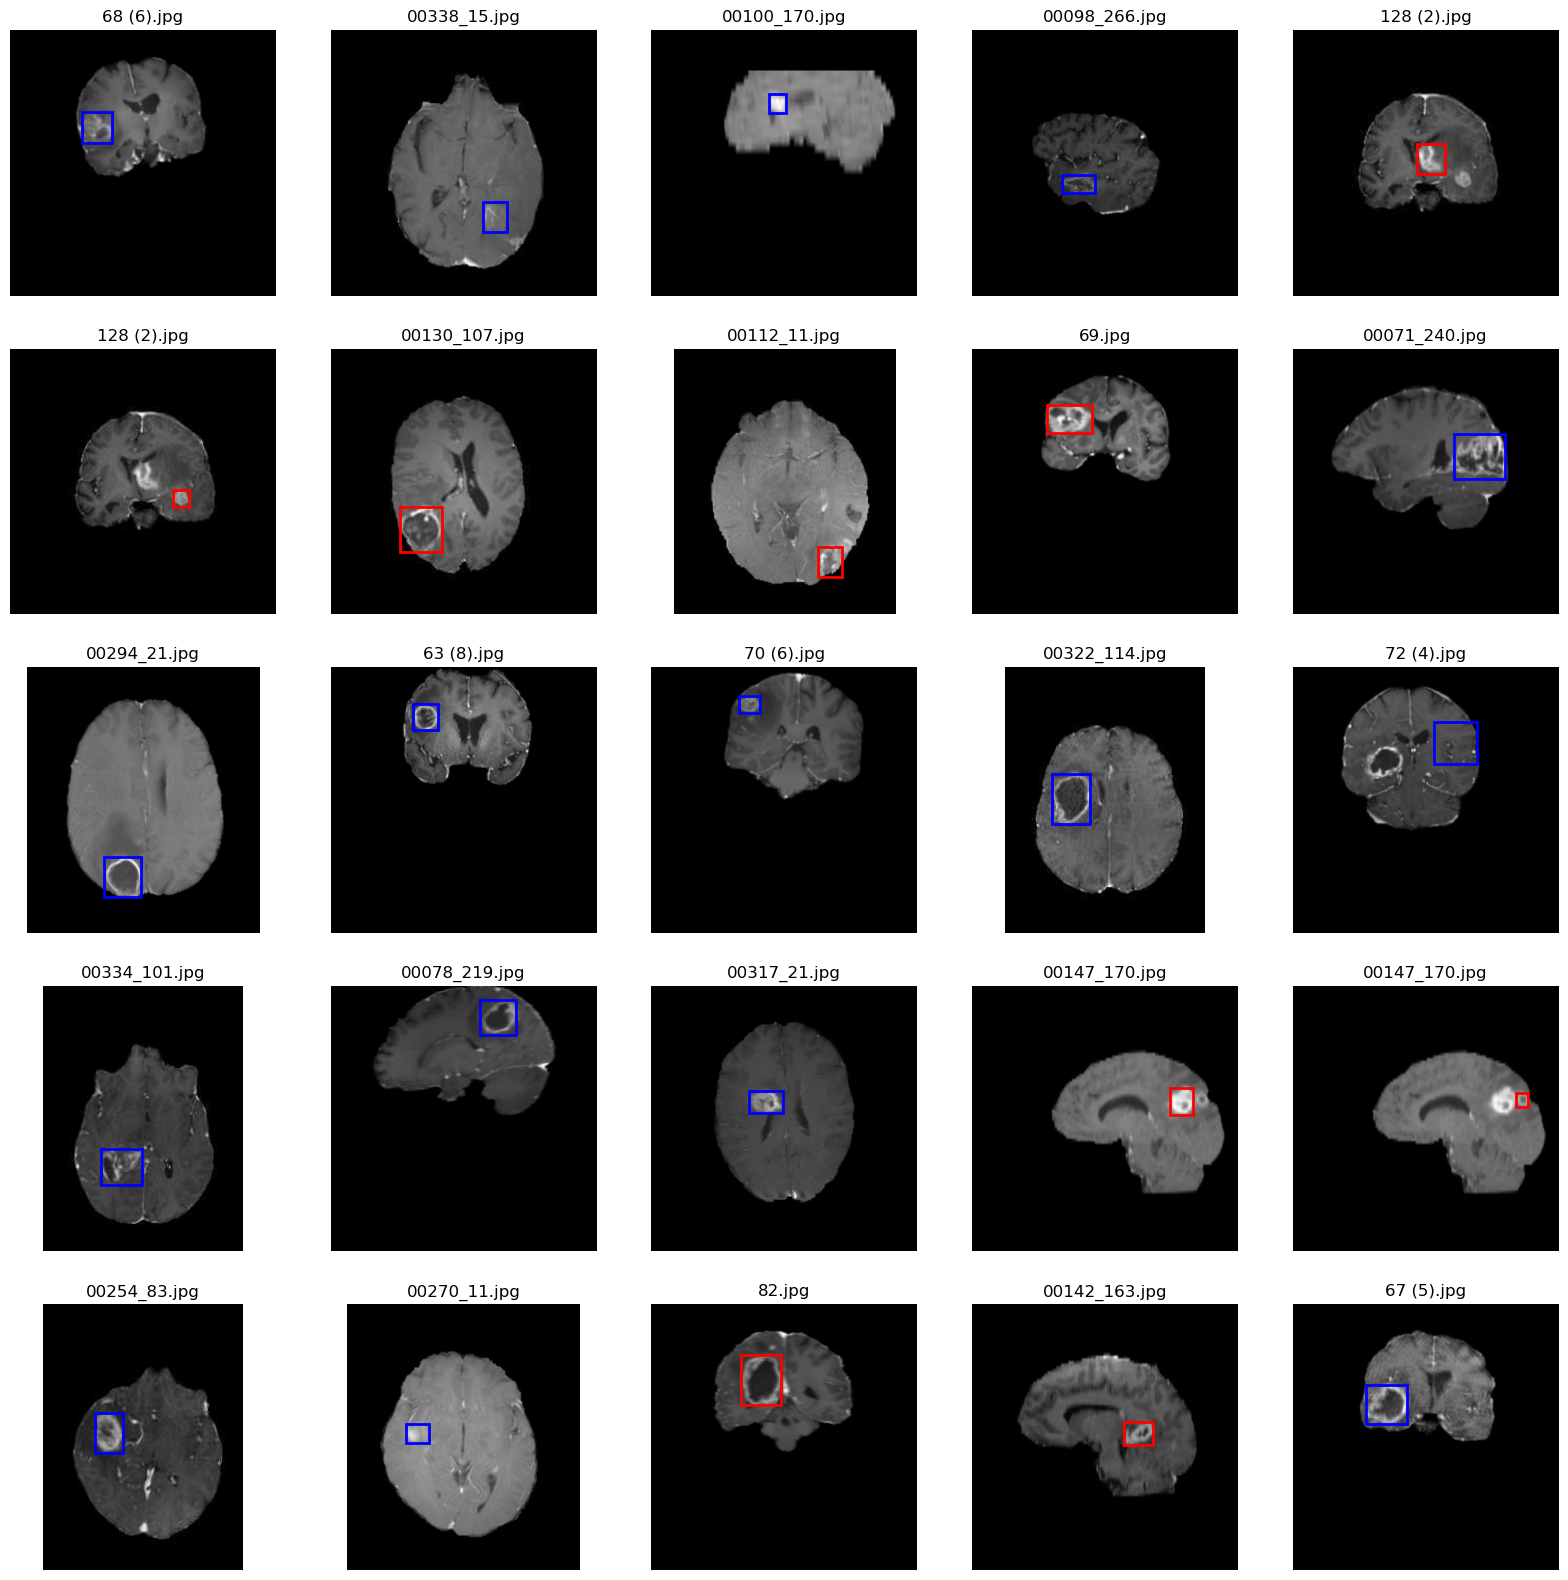

In [13]:
show_images(names[:25], images[:25], labels[:25])

In [14]:
model = YOLO("yolo11x.pt")
model.to("cuda")

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(384, eps=0.001, momentum=0.03, affine=True, track_

In [15]:
(test_names, test_images, test_labels, test_unlabeled) = dir_to_data(test_dir)
test_predictions = model.predict(source=test_images[:20], save=True, save_txt=True)

Total of 74 images found
Total of 81 labeled images found (some may contain duplicate labels)
Total of 0 unlabeled images found
Class distribution:  {'negative': 47, 'positive': 34}

0: 640x640 (no detections), 19.4ms
1: 640x640 1 donut, 19.4ms
2: 640x640 (no detections), 19.4ms
3: 640x640 1 vase, 19.4ms
4: 640x640 1 donut, 19.4ms
5: 640x640 1 apple, 1 vase, 19.4ms
6: 640x640 1 teddy bear, 19.4ms
7: 640x640 1 person, 19.4ms
8: 640x640 1 apple, 19.4ms
9: 640x640 (no detections), 19.4ms
10: 640x640 (no detections), 19.4ms
11: 640x640 (no detections), 19.4ms
12: 640x640 1 bird, 19.4ms
13: 640x640 1 person, 19.4ms
14: 640x640 1 bird, 19.4ms
15: 640x640 1 donut, 19.4ms
16: 640x640 1 donut, 19.4ms
17: 640x640 1 tie, 19.4ms
18: 640x640 1 tie, 19.4ms
19: 640x640 (no detections), 19.4ms
Speed: 1.4ms preprocess, 19.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict22
14 labels saved to runs/detect/predict22/labels


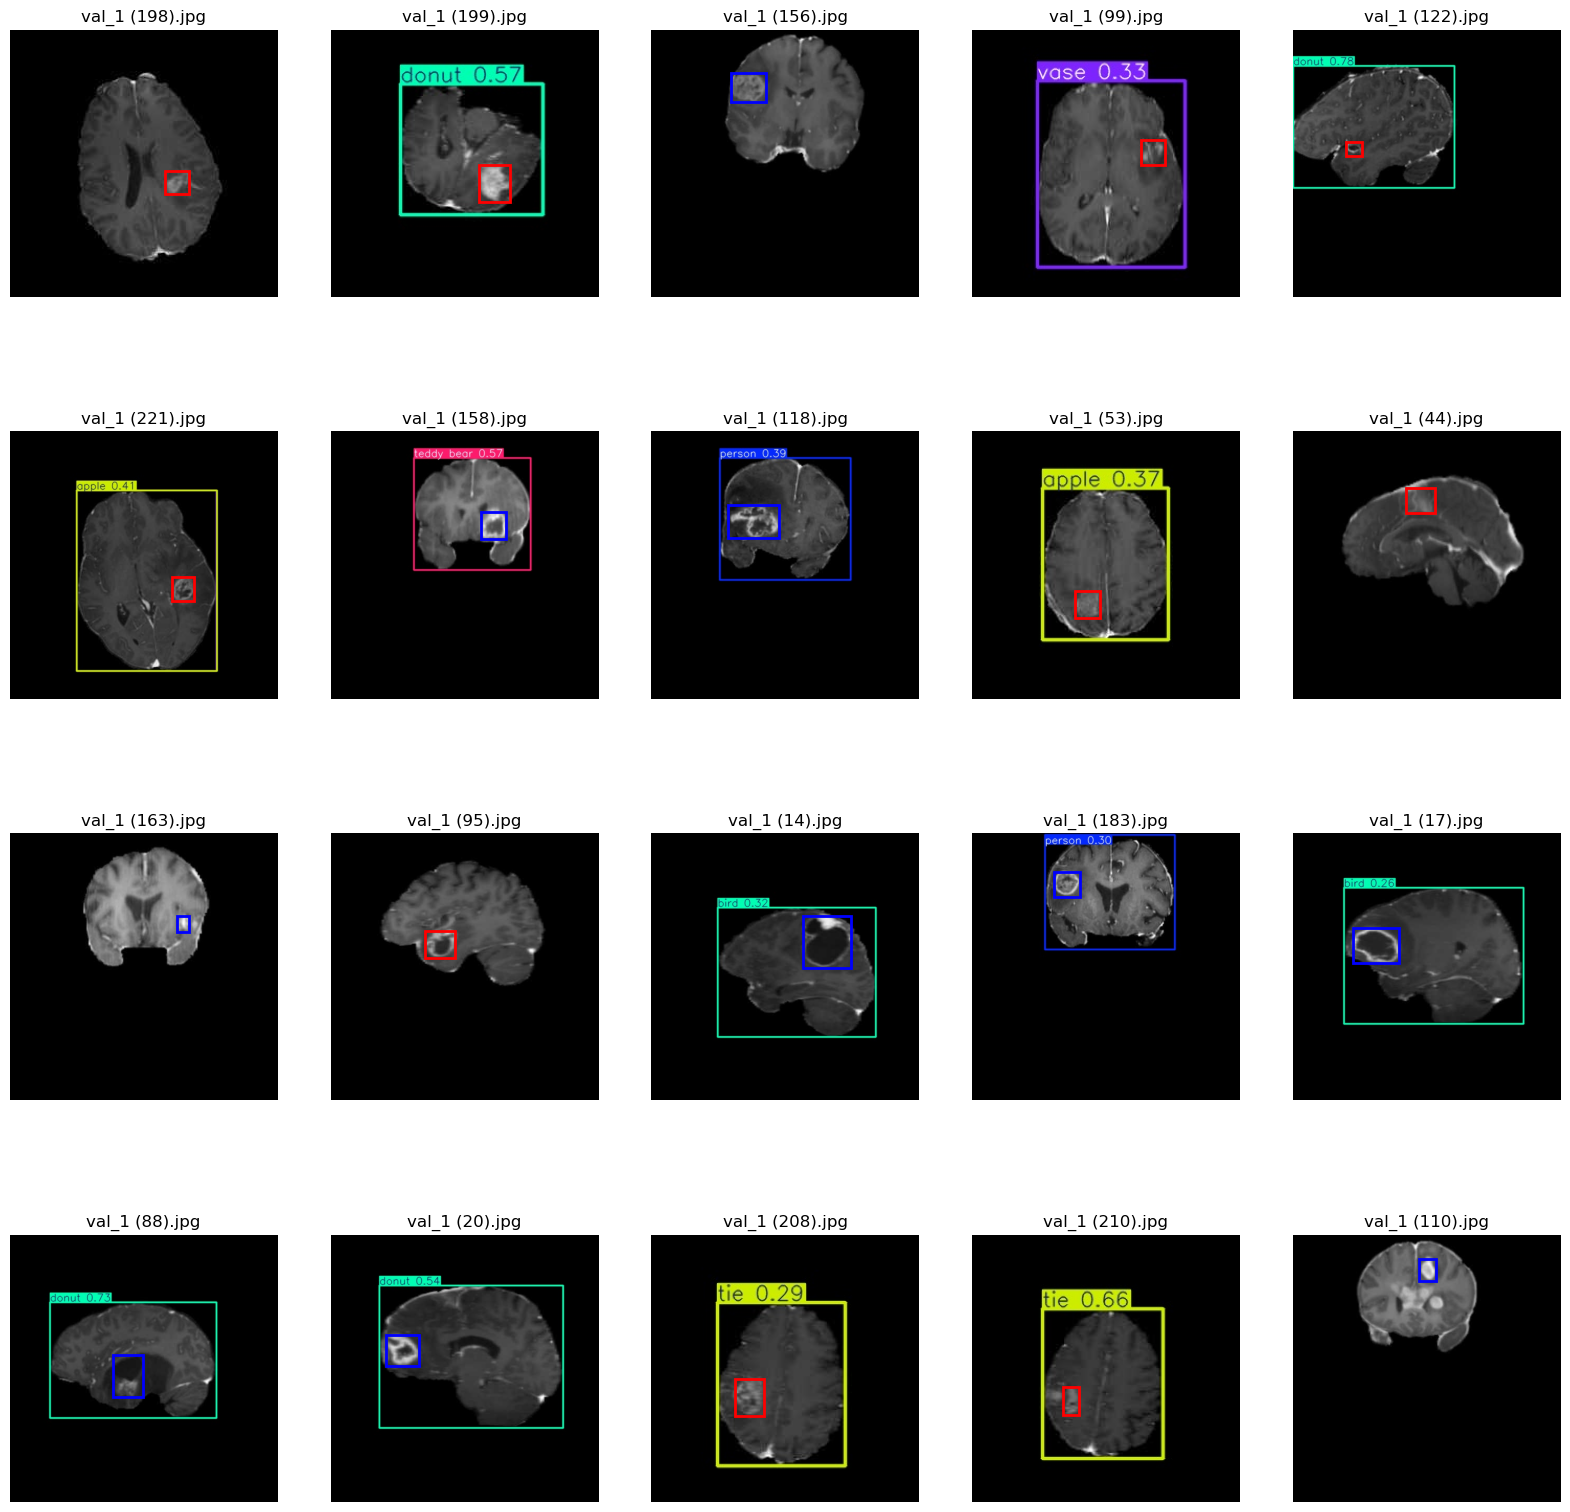

In [16]:
def show_predictions(names, predictions, true_labels):
    images = []
    for pred in predictions:
        img_path = os.path.join(pred.save_dir, pred.path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        images.append(img)

    show_images(names, images, true_labels)

# Show pretrained predictions. 
# These don't make sense, but it's to verify that we're using a basic YOLO model before we start.
show_predictions(test_names[:20], test_predictions, test_labels[:20])

In [17]:
train_config_path = os.path.join(base_dir, "data.yaml")
with open(train_config_path, 'w') as f:
    cfg = {
        'path': 'brain-tumor',
        'train': os.path.join("train", "images"),
        'val': os.path.join("valid", "images"),
        'test': os.path.join("test", "images"),
        'names': class_mapping,
        'nc': 2
    }

    yaml.dump(cfg, f)

In [18]:
print_mem()

metrics = model.train(
    data=train_config_path, 
    imgsz=512,
    # Training params
    epochs=30,
    batch=16,
    patience=30,
    lr0=0.001,
    lrf=0.0001,
    weight_decay=0.0005,
    warmup_epochs=5,
    optimizer='AdamW',
    conf=0.3,
    cls=1.5,
    # Data augmentation
    augment=True,
    mosaic=1.0,
    mixup=0.15,
    degrees=0.3,
    fliplr=0.5,
    flipud=0.25,
)
print_mem()
metrics.save_dir

CUDA mem usage: 6.0/12.5GB (48.5%)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=./datasets/data.yaml, epochs=30, time=None, patience=30, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.3, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=F

train: Scanning /home/jovyan/notebooks/BrainScan/datasets/brain-tumor/train/labels.cache... 878 images, 15 backgrounds, 0 corrupt: 
val: Scanning /home/jovyan/notebooks/BrainScan/datasets/brain-tumor/valid/labels.cache... 149 images, 0 backgrounds, 0 corrupt: 100


Plotting labels to runs/detect/train15/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs/detect/train15
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30        10G      1.602      6.615      1.458         31        512: 100%|██████████| 56/56 [00:22<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.43i

                   all        149        160        0.2     0.0187      0.108     0.0868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      10.2G      1.135      3.812      1.066         26        512: 100%|██████████| 56/56 [00:21<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69i

                   all        149        160      0.485      0.766      0.474      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      10.2G      1.147      3.662      1.084         23        512: 100%|██████████| 56/56 [00:20<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70i

                   all        149        160      0.475      0.559      0.413      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       6.4G      1.145      3.521      1.077         20        512: 100%|██████████| 56/56 [00:20<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.06i

                   all        149        160      0.439      0.394      0.335      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      6.41G      1.085      3.464      1.056         19        512: 100%|██████████| 56/56 [00:20<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01i

                   all        149        160      0.447      0.606      0.378      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.51G      1.119      3.514      1.076         19        512: 100%|██████████| 56/56 [00:20<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.03i

                   all        149        160      0.489      0.681      0.433      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.73G      1.061      3.395      1.044         28        512: 100%|██████████| 56/56 [00:20<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95i

                   all        149        160      0.447      0.527      0.341      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      6.43G      1.064      3.294      1.066         17        512: 100%|██████████| 56/56 [00:20<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94i

                   all        149        160      0.447      0.673      0.383      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.31G       1.02      3.107      1.045         25        512: 100%|██████████| 56/56 [00:20<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00i

                   all        149        160      0.385        0.5      0.308      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.47G      1.062      3.101      1.061         18        512: 100%|██████████| 56/56 [00:20<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01i

                   all        149        160      0.485      0.569       0.41        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       6.3G      1.008      2.915      1.039         22        512: 100%|██████████| 56/56 [00:20<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01i

                   all        149        160      0.478       0.52      0.434      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.29G      1.047      3.004      1.065         27        512: 100%|██████████| 56/56 [00:20<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.05i

                   all        149        160      0.501      0.615      0.465      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.12G      1.012      3.029       1.06         21        512: 100%|██████████| 56/56 [00:20<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01i

                   all        149        160      0.484      0.649      0.414      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.17G       1.02      3.027      1.061         14        512: 100%|██████████| 56/56 [00:20<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92i

                   all        149        160       0.43      0.577      0.371      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.59G     0.9879      2.935      1.037         20        512: 100%|██████████| 56/56 [00:20<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92i

                   all        149        160      0.482        0.6      0.401      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      6.54G     0.9729      2.738      1.034         23        512: 100%|██████████| 56/56 [00:20<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95i

                   all        149        160      0.456      0.494      0.355       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      6.35G     0.9563       2.82      1.027         17        512: 100%|██████████| 56/56 [00:20<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76i

                   all        149        160       0.46      0.583      0.376      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      6.05G      0.975      2.732      1.045         23        512: 100%|██████████| 56/56 [00:20<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82i

                   all        149        160      0.461      0.559      0.389      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.88G     0.9304      2.698      1.016         30        512: 100%|██████████| 56/56 [00:20<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92i

                   all        149        160      0.538      0.789      0.537       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.94G     0.9566      2.615      1.019         28        512: 100%|██████████| 56/56 [00:20<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92i

                   all        149        160      0.481      0.677      0.484      0.382


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.32G     0.8749      2.454     0.9963         15        512: 100%|██████████| 56/56 [00:20<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.90i

                   all        149        160      0.541      0.607      0.478      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.21G     0.8662       2.27     0.9842         13        512: 100%|██████████| 56/56 [00:20<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75i

                   all        149        160      0.488      0.612      0.418      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.14G     0.8395      2.191     0.9698         12        512: 100%|██████████| 56/56 [00:20<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.90i

                   all        149        160      0.528      0.667      0.548      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.22G     0.8448      2.274     0.9759         15        512: 100%|██████████| 56/56 [00:20<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94i

                   all        149        160        0.5      0.667      0.476      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.54G     0.8124      2.078     0.9753         13        512: 100%|██████████| 56/56 [00:20<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84i


                   all        149        160      0.558      0.649      0.524      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      7.11G     0.8124      1.955     0.9621         13        512: 100%|██████████| 56/56 [00:21<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83i


                   all        149        160      0.544        0.7       0.55      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.33G     0.7949      1.908     0.9742         13        512: 100%|██████████| 56/56 [00:20<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.02i

                   all        149        160      0.545      0.668       0.54       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.83G     0.8018      1.854     0.9711         14        512: 100%|██████████| 56/56 [00:20<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.90i

                   all        149        160      0.549       0.71      0.566      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.35G     0.7981      1.803     0.9681         14        512: 100%|██████████| 56/56 [00:20<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97i

                   all        149        160      0.479      0.634       0.45      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.99G     0.7892      1.736     0.9677         16        512: 100%|██████████| 56/56 [00:20<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.96i

                   all        149        160      0.543      0.625        0.5      0.402



30 epochs completed in 0.190 hours.
Optimizer stripped from runs/detect/train15/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/train15/weights/best.pt, 114.4MB

Validating runs/detect/train15/weights/best.pt...
Ultralytics 8.3.77 🚀 Python-3.11.8 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4070, 11877MiB)
YOLO11x summary (fused): 190 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68i


                   all        149        160      0.528       0.71      0.556      0.442
              negative         98        107      0.656      0.553      0.611      0.495
              positive         51         53        0.4      0.868        0.5      0.388
Speed: 0.1ms preprocess, 18.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train15
CUDA mem usage: 6.4/12.5GB (51.1%)


PosixPath('runs/detect/train15')

In [19]:
def show_metrics(metrics):
    images = [
        'results.png', 
        'confusion_matrix_normalized.png',
        'F1_curve.png',         
        'P_curve.png',
        'PR_curve.png',
        'R_curve.png'
    ]
    
    fig, axs = plt.subplots(int(len(images) / 2), 2, figsize=(50, 50))
    axs = axs.flatten()
    
    for i, img_path in enumerate(images):
        path = os.path.join(metrics.save_dir, img_path)
        if os.path.exists(path):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
            axs[i].imshow(img)
            axs[i].axis("off")

show_metrics(metrics)


0: 512x512 2 positives, 10.6ms
1: 512x512 1 negative, 1 positive, 10.6ms
2: 512x512 1 negative, 1 positive, 10.6ms
3: 512x512 1 positive, 10.6ms
4: 512x512 1 negative, 1 positive, 10.6ms
5: 512x512 1 negative, 10.6ms
6: 512x512 1 positive, 10.6ms
7: 512x512 2 positives, 10.6ms
8: 512x512 1 positive, 10.6ms
9: 512x512 1 negative, 1 positive, 10.6ms
10: 512x512 1 negative, 10.6ms
11: 512x512 1 positive, 10.6ms
12: 512x512 1 negative, 1 positive, 10.6ms
13: 512x512 1 positive, 10.6ms
14: 512x512 1 positive, 10.6ms
15: 512x512 1 positive, 10.6ms
16: 512x512 1 positive, 10.6ms
17: 512x512 1 negative, 1 positive, 10.6ms
18: 512x512 1 positive, 10.6ms
19: 512x512 2 negatives, 2 positives, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict24


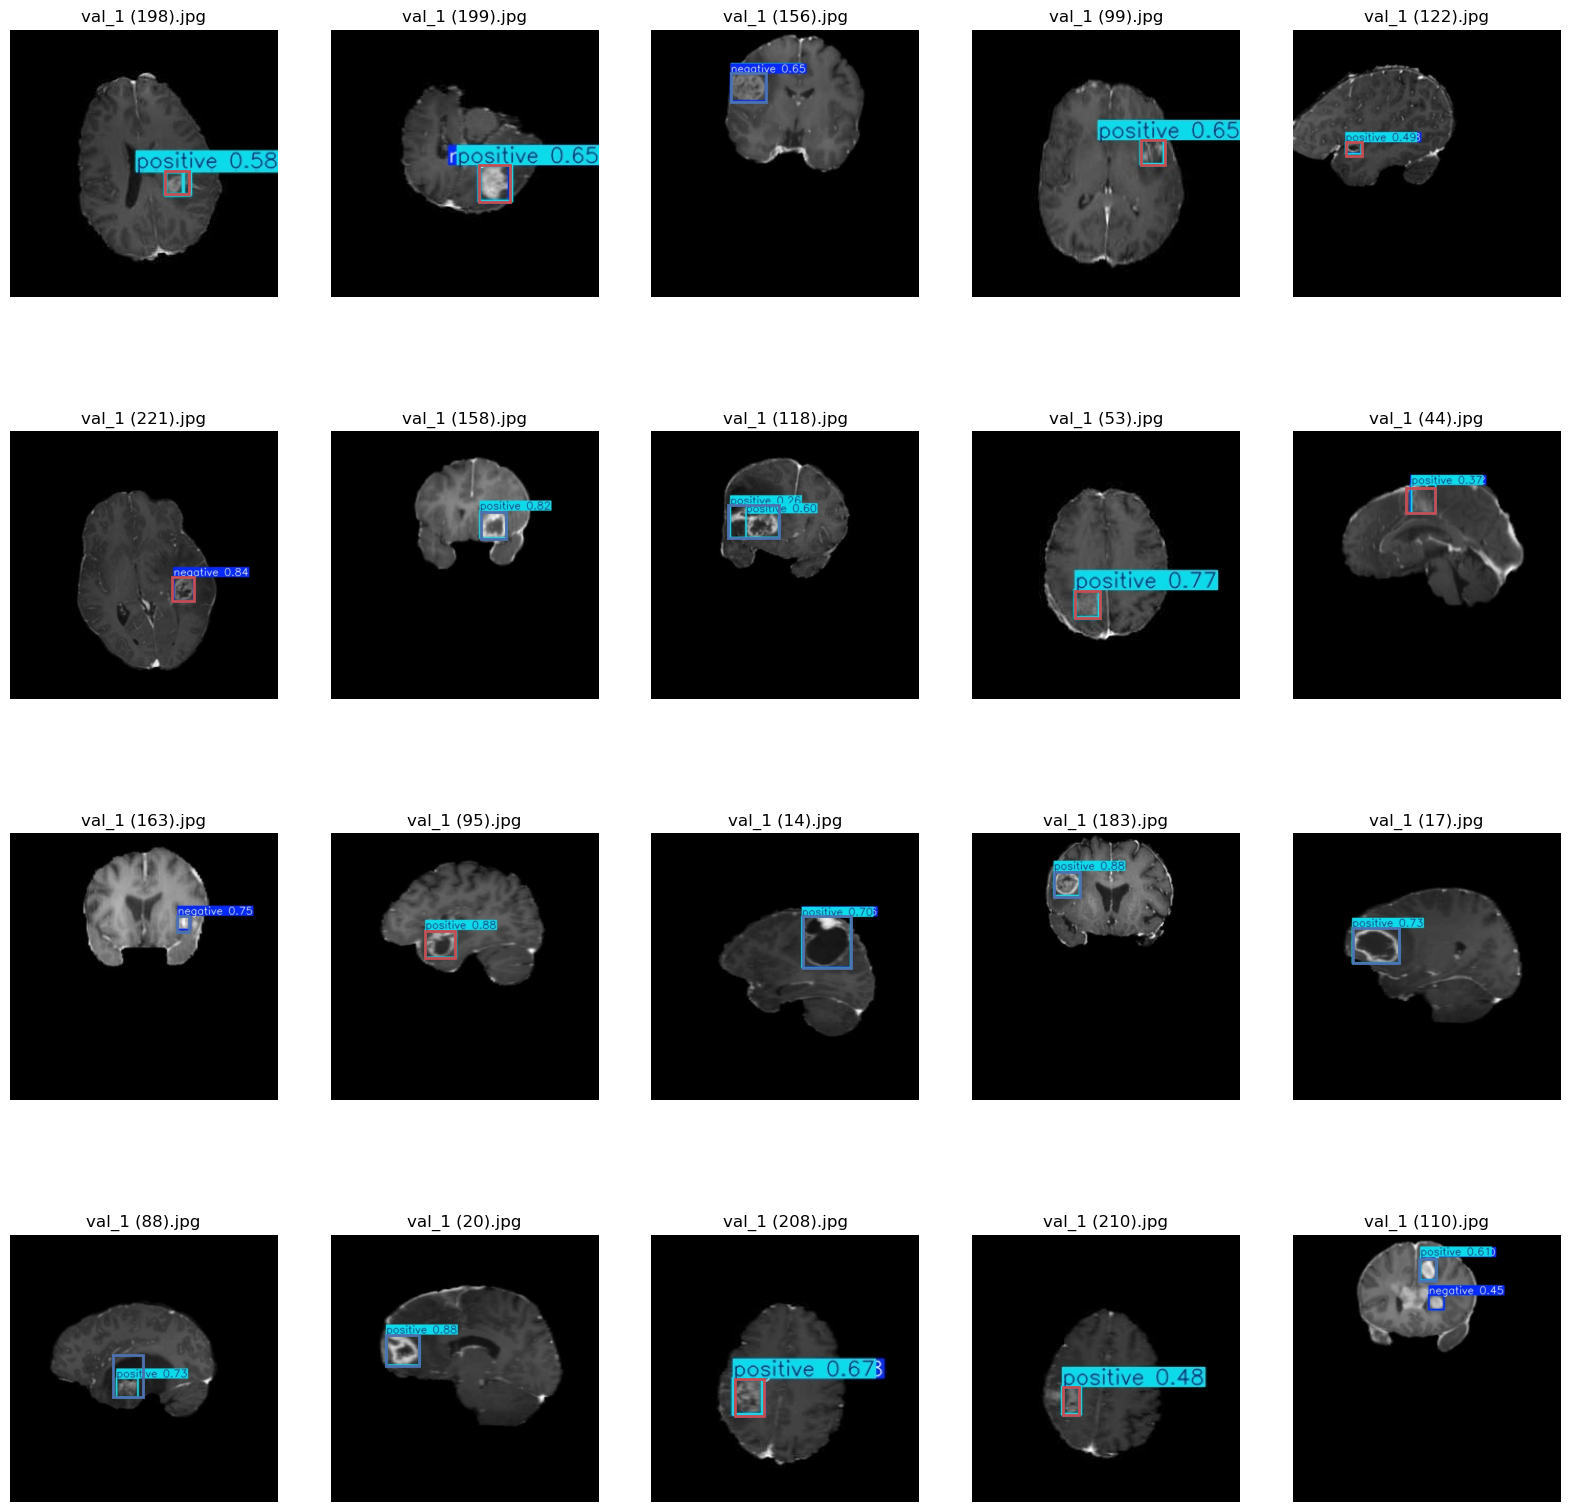

In [23]:
best_weights = "runs/detect/train15/weights/best.pt"
best_model = YOLO(best_weights, task="detect")
trained_predictions = best_model.predict(source=test_images[:20], save=True)

show_predictions(test_names[:20], trained_predictions, test_labels[:20])

Ultralytics 8.3.77 🚀 Python-3.11.8 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4070, 11877MiB)


val: Scanning /home/jovyan/notebooks/BrainScan/datasets/brain-tumor/test/labels.cache... 74 images, 0 backgrounds, 0 corrupt: 100%|
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.48i


                   all         74         81      0.533      0.724      0.602      0.458
              negative         44         47      0.699      0.743      0.694      0.528
              positive         30         34      0.366      0.706       0.51      0.387
Speed: 1.0ms preprocess, 11.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val15
runs/detect/val15


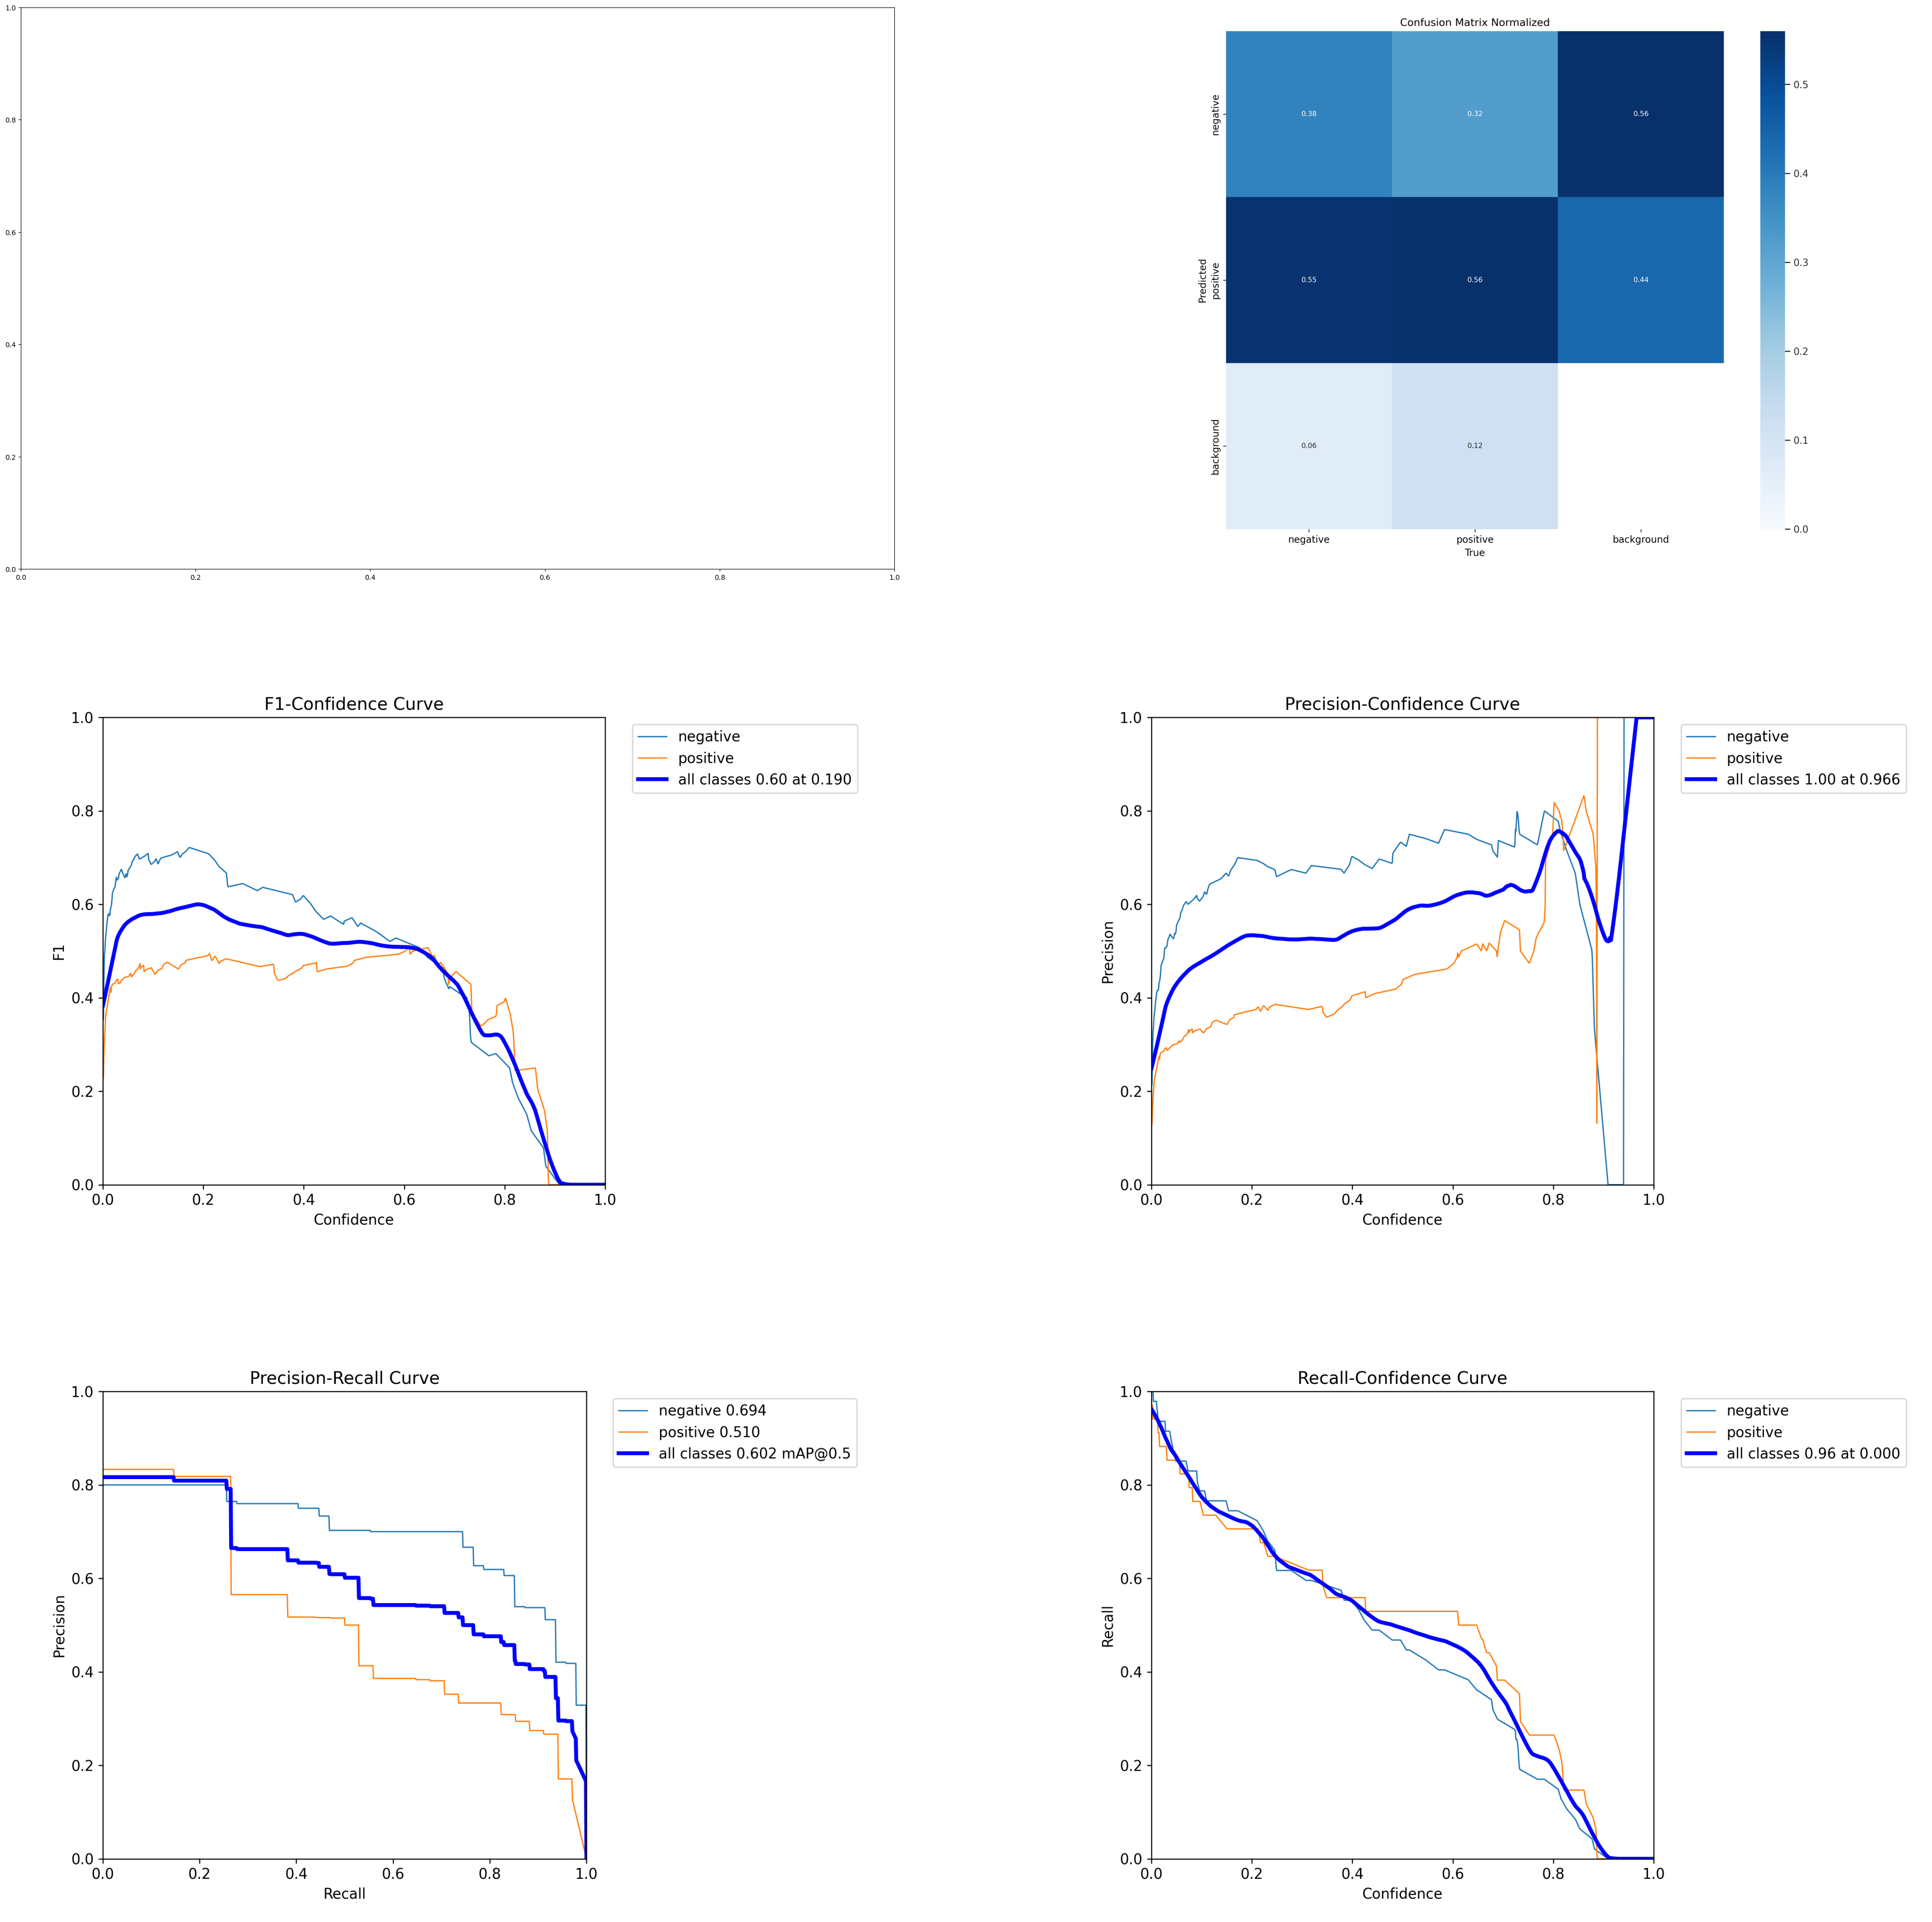

In [28]:
validation_metrics = best_model.val(split='test')
print(validation_metrics.save_dir)
show_metrics(validation_metrics)